# Exercise: Run a cluster analysis


**Goal**:
You will use the skills you've learned throughout the course to conduct two analyses where you compute the Moran's I statistic. Additionally, you will explore how to run a sptial correlation between two variables.

**Step 1**
Load the `Toronto_Neighbourhoods.geojson` and `toronto_health_data_2017.csv` files into python.

**Step 2**
Merge the health data with the spatial data

**Step 3**
Generate maps of two of the three health variables included in the dataset (e.g., pick diabetes and mental health, or mental health and asthma). Make sure to classify the data and make it look nice. 

For each of the two columns do the following to pratice *spatial autocorrelation*:

**Step 4**
Calculate a weights matrix using `libpysal` (referred to as `lps` below).
*Hint* The function is `lps.weights.Queen.from_dataframe`.

**Step 5**
Use the `esda.Moran()` function to calculate the moran's I statistic and plot it. 

**Step 6**
Use the `esda.Moran_Local()` function to calculate the LISA statistic and plot it.

**Step 7**
Interpret the global and local Moran's statistics in a few sentences. What do they tell us about the spatial distribution of the two health outcomes you selected?

Do the following steps to explore *spatial correlation*

**Step 8**
Two options to conduct sptial correlation:
1. Use a linear regression between the spatial lags of one health outcomes and the spatial lags of the other one.
2. Calcuating Lee's L statistics (similar with Moran's I, but apply to two or more variables). See [wiki](https://en.wikipedia.org/wiki/Lee%27s_L) and [esda.Spatial_pearson](https://pysal.org/esda/generated/esda.Spatial_Pearson.html) for how to do it.

**Step 9**
Interpret the spatial correlation results. Do they tell us whether the spatial distribution of the two health outcomes are similar?

In [67]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import esda
import splot
import libpysal as lps
import contextily as cx
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from statsmodels.formula.api import ols

In [2]:
#start your code here - add cells as needed

In [3]:
# 1) import data and clean

## Neighborhood data
nbrhd = gpd.GeoDataFrame.from_file("Toronto_Neighbourhoods.geojson")
important_spat_cols = nbrhd.columns[[4, 5, 17]]
colnames_spat = {important_spat_cols[0]: 'name',
           important_spat_cols[1] : 'nbrhd_spat_id',
           important_spat_cols[2] : 'geometry'}
nbrhd_simple = nbrhd.copy()
nbrhd_simple = nbrhd_simple[important_spat_cols]
nbrhd_simple.rename(columns = colnames_spat, inplace=True)

# remember to change the data type of neighbor id
nbrhd_simple["Neighbid"] = nbrhd_simple["nbrhd_spat_id"].astype(int) 
nbrhd_simple.head()

,name,nbrhd_spat_id,geometry,Neighbid
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96
1,Annex (95),095,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",95
2,Caledonia-Fairbank (109),109,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",109
3,Woodbine Corridor (64),064,"POLYGON ((-79.31485 43.66674, -79.3166 43.6663...",64
4,Lawrence Park South (103),103,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",103


In [4]:
## Health data

health = pd.read_csv('toronto_health_data_2017.csv')
health_rename_dict = {
    'NeighbID': 'Neighbid',
    'prev_diab_20up': 'diabetes',
    'prev_asthma_0up': 'asthma',
    'prev_mh_20up': 'mentalhealth'
}
health.rename(columns = health_rename_dict, inplace=True)
health.head()

,Neighbid,Name,diabetes,asthma,mentalhealth
0,1,West Humber-Clairville,18.2,15.9,7.2
1,2,Mount Olive-Silverstone-Jamestown,18.4,14.6,8.1
2,3,Thistletown-Beaumond Heights,17.7,16.0,8.4
3,4,Rexdale-Kipling,17.5,16.7,9.0
4,5,Elms-Old Rexdale,17.0,19.0,8.9


In [5]:
## Check the order of the neighborhood id
nbrhd_simple.sort_values(by = 'Neighbid').head()

,name,nbrhd_spat_id,geometry,Neighbid
30,West Humber-Clairville (1),001,"POLYGON ((-79.55236 43.70947, -79.55238 43.709...",1
40,Mount Olive-Silverstone-Jamestown (2),002,"POLYGON ((-79.60338 43.75786, -79.60205 43.758...",2
124,Thistletown-Beaumond Heights (3),003,"POLYGON ((-79.57751 43.73384, -79.57806 43.734...",3
122,Rexdale-Kipling (4),004,"POLYGON ((-79.55512 43.7151, -79.55504 43.7148...",4
22,Elms-Old Rexdale (5),005,"POLYGON ((-79.55512 43.7151, -79.55569 43.7163...",5


In [6]:
# 2) Merge health data to neighbhorhood

nbrhd_health = nbrhd_simple.merge(health, on='Neighbid')
nbrhd_health.head()

,name,nbrhd_spat_id,geometry,Neighbid,Name,diabetes,asthma,mentalhealth
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96,Casa Loma,8.1,13.6,9.3
1,Annex (95),095,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",95,Annex,7.4,12.4,9.7
2,Caledonia-Fairbank (109),109,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",109,Caledonia-Fairbank,14.3,16.6,9.8
3,Woodbine Corridor (64),064,"POLYGON ((-79.31485 43.66674, -79.3166 43.6663...",64,Woodbine Corridor,8.9,14.7,10.3
4,Lawrence Park South (103),103,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",103,Lawrence Park South,6.2,14.7,8.3


<Axes: >

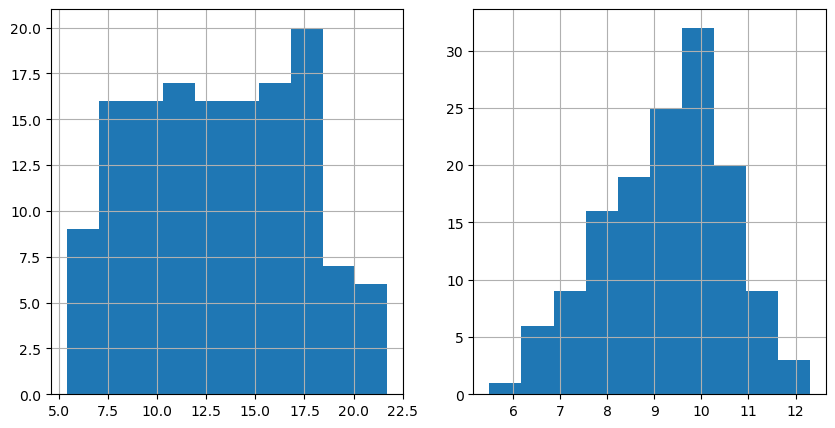

In [7]:
# 3) Map two health outcome variables. We pick diabetes and mentalhealth here

## Before mapping, it is a good idea to see the distribution of the variables

fig, axes = plt.subplots(1, 2, figsize=(10,5))

nbrhd_health.diabetes.hist(ax=axes[0], bins=10)
nbrhd_health.mentalhealth.hist(ax=axes[1], bins=10)


Text(0.5, 1.0, 'Mental Health')

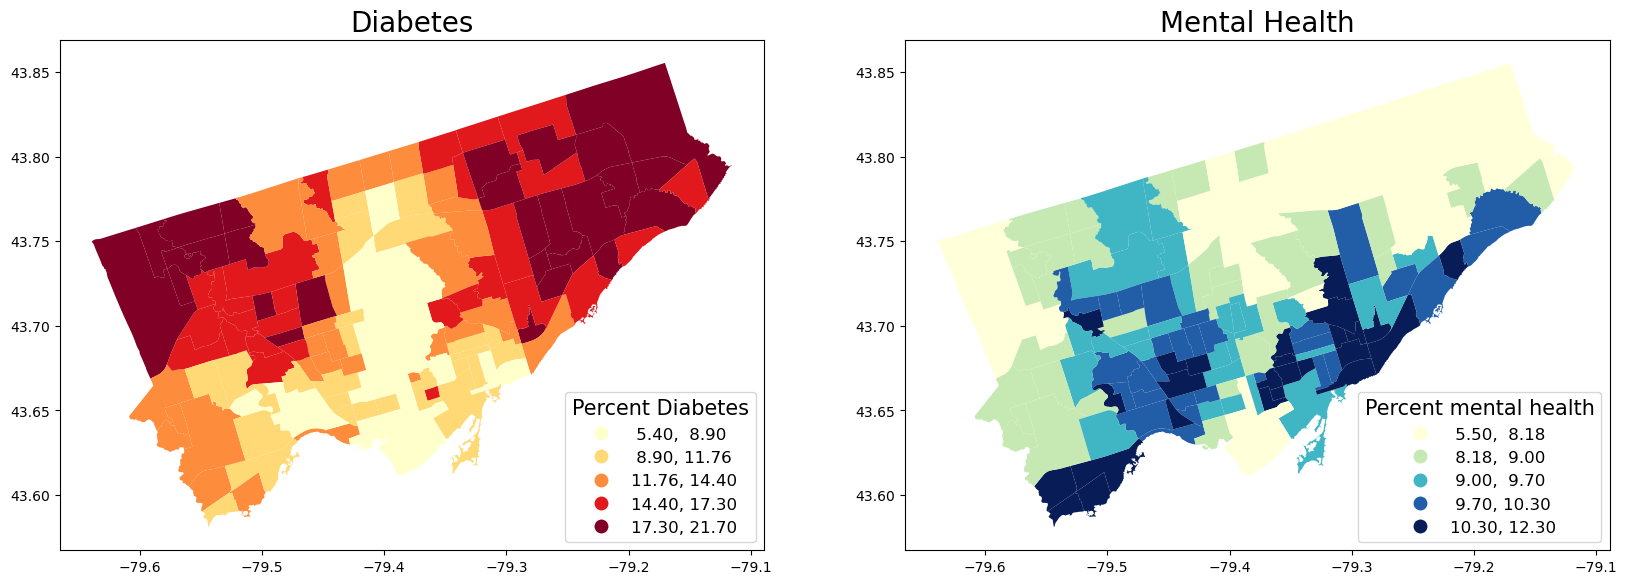

In [8]:
## Map the variables in quantiles
fig, axes = plt.subplots(1, 2, figsize=(20,20))

nbrhd_health.plot(column = 'diabetes', cmap = 'YlOrRd', 
                  scheme='quantiles',k=5, ax=axes[0],
                 legend=True, legend_kwds={'loc': 4, 'title': 'Percent Diabetes', 
                               'title_fontsize': 15,'fontsize': 12})
nbrhd_health.plot(column = 'mentalhealth', cmap = 'YlGnBu', scheme='quantiles',k=5, ax=axes[1],
                legend=True, legend_kwds={'loc': 4, 'title': 'Percent mental health', 
                               'title_fontsize': 15,'fontsize': 12})

axes[0].set_title("Diabetes", fontsize = 20)
axes[1].set_title("Mental Health", fontsize = 20)

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

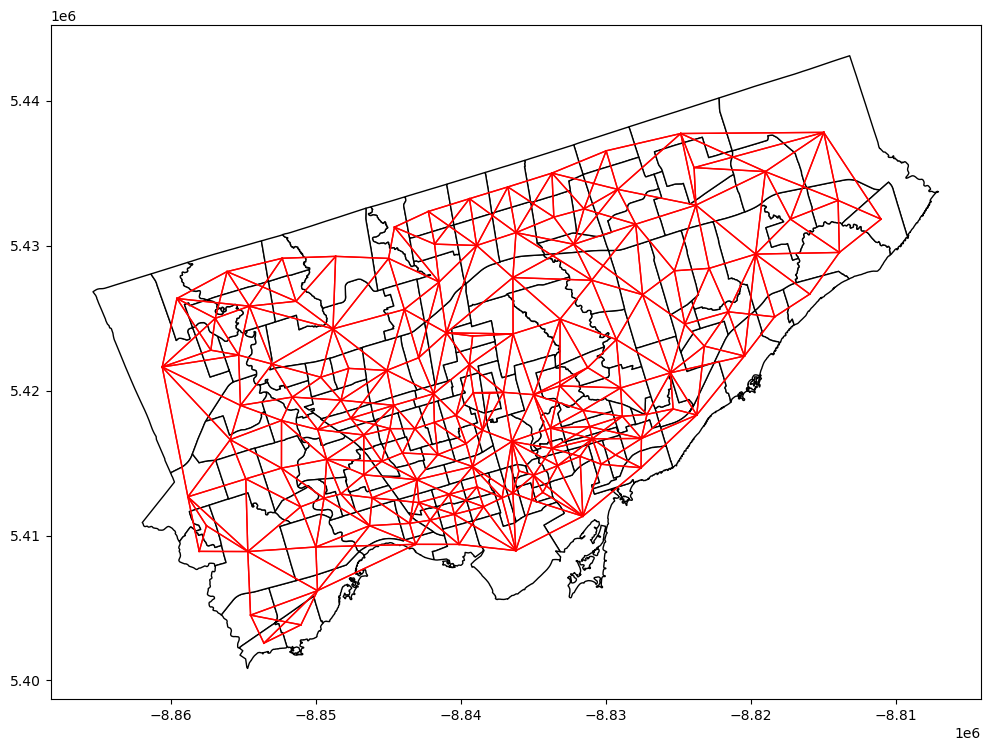

In [15]:
# For each variable
# 4) calculate a weight matrix
## Note: the weight matrix is the same for both variables

## Reproject the gdf to a projection coordinate system
nbrhd_health = nbrhd_health.to_crs("EPSG:3857")

## Create Queen's contiguity weight matrix
w = lps.weights.Queen.from_dataframe(nbrhd_health, use_index=False)

## Normalization
w.transform = 'R'

## Plot the contiguity matrix
fig, axes = plt.subplots(1,1, figsize = (12,12))
nbrhd_health.plot(ax = axes, edgecolor = 'black', facecolor = 'w')
w.plot(nbrhd_health, ax=axes, 
        edge_kws=dict(color='r', linewidth=1),
        node_kws=dict(marker=''))

The Morans I value is:  0.781042692582945
The p-value of this Morans I value is:  0.001


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Scatterplot (0.78)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

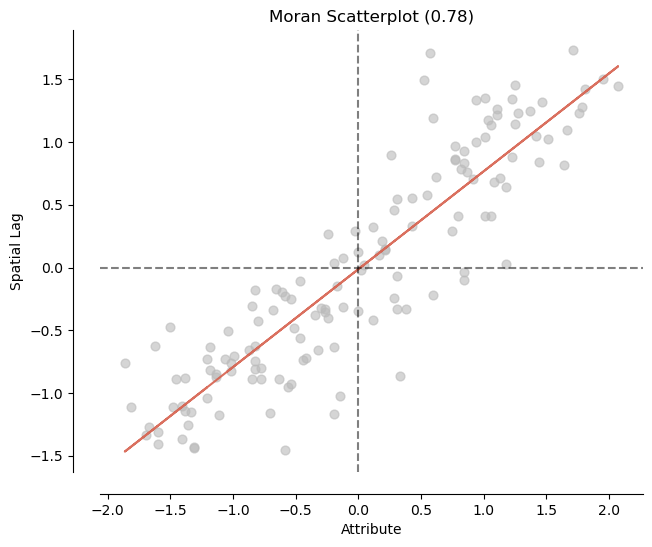

In [10]:
# 5) Calculate the global Moran's I and plot it

## Diabetes

mi_diabetes = esda.Moran(nbrhd_health['diabetes'], w)

print('The Morans I value is: ', mi_diabetes.I)
print('The p-value of this Morans I value is: ', mi_diabetes.p_sim)

#visualize!
splot.esda.moran_scatterplot(mi_diabetes)

The Morans I value is:  0.6056281976101754
The p-value of this Morans I value is:  0.001


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Scatterplot (0.61)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

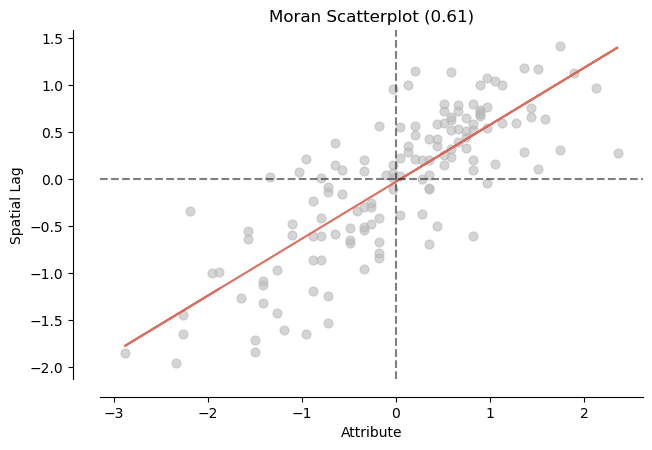

In [11]:
## Mental health

mi_mentalhealth = esda.Moran(nbrhd_health['mentalhealth'], w)

print('The Morans I value is: ', mi_mentalhealth.I)
print('The p-value of this Morans I value is: ', mi_mentalhealth.p_sim)

#visualize!
splot.esda.moran_scatterplot(mi_mentalhealth)

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

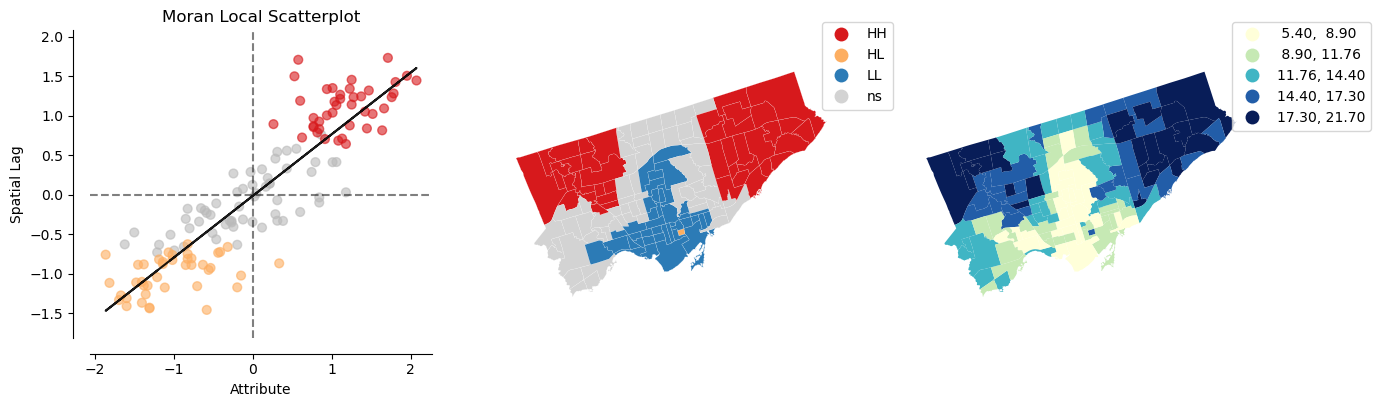

In [12]:
# 6) Calculate local cluster indicator LISA

## diabetes
lisa_diabetes = esda.Moran_Local(nbrhd_health['diabetes'], w)
splot.esda.plot_local_autocorrelation(lisa_diabetes, nbrhd_health, 'diabetes')

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

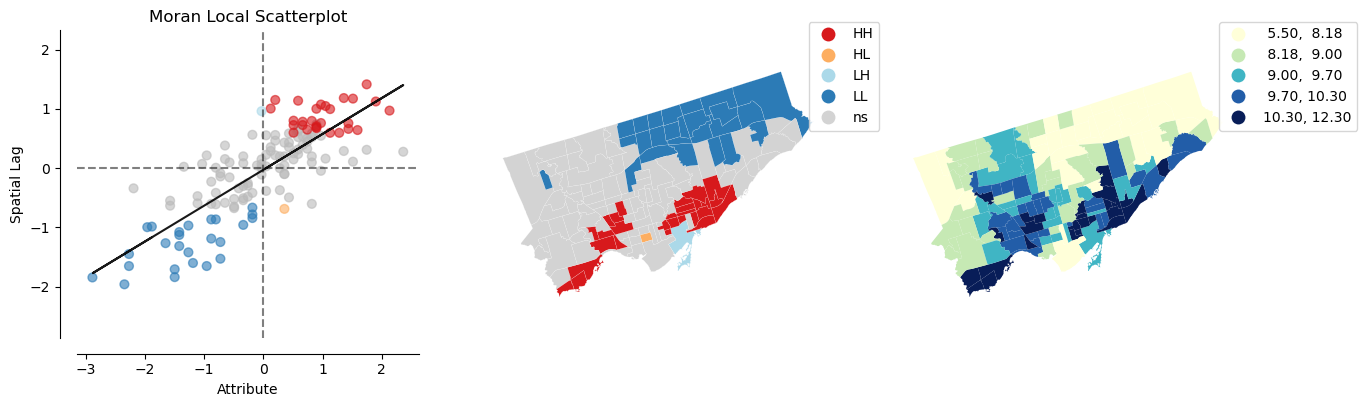

In [13]:
## mental health
lisa_mentalhealth = esda.Moran_Local(nbrhd_health['mentalhealth'], w)
splot.esda.plot_local_autocorrelation(lisa_mentalhealth, nbrhd_health, 'mentalhealth')

### 7) Interpretation of spatial autocorrelation (cluster analysis)
 Make your interpretation here!

In [69]:
# 8) explore spatial correlation – regress spatiall weighted diabetes on weighted mental health

## Get spatial lags of these two variables
nbrhd_health['w_diabetes'] = lps.weights.lag_spatial(w, nbrhd_health['diabetes'])
nbrhd_health['w_mentalhealth'] = lps.weights.lag_spatial(w, nbrhd_health['mentalhealth'])

## Conduct linear regression on the spatial lags
reg_w_diabetes_mental = ols('w_mentalhealth ~ w_diabetes', data = nbrhd_health).fit()
reg_w_diabetes_mental_sum = reg_w_diabetes_mental.summary()
reg_w_diabetes_mental_sum.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.4901,0.293,35.753,0.000,9.910,11.070
w_diabetes,-0.0983,0.022,-4.543,0.000,-0.141,-0.056


In [70]:
## Normal linear regression as a comparison

reg_diabetes_mental = ols('mentalhealth ~ diabetes', data = nbrhd_health).fit()
reg_diabetes_mental_sum = reg_diabetes_mental.summary()
reg_diabetes_mental_sum.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.9831,0.360,27.694,0.000,9.270,10.696
diabetes,-0.0566,0.026,-2.162,0.032,-0.108,-0.005


In [65]:
# 8) explore spatial correlation - Alternative: use Lee's L estimator

# Initialize caculator
lee = esda.Spatial_Pearson(w.sparse)
var1 = nbrhd_health['diabetes'].values.reshape(-1,1)
var2 = nbrhd_health['mentalhealth'].values.reshape(-1,1)

# Get Lee.L for spatial correlation
lee.fit(var1, var2)

# Get the correlation matrix and significance
# Lee'L statistics are the one in upper right and lower left
print(lee.association_)
print(lee.significance_)

[[ 0.76092951 -0.23864889]
 [-0.23864889  0.57789521]]
[[0.001 0.001]
 [0.001 0.001]]


### 9) Interpretation of spatial correlation

 - The spatial lags of diabetes is negatively associated with the spatial lags of mental health.
 - Lee's L is also significant and negative (negative association).
 - This means that these two health conditions have a reverse sptial distribution.
 - Also considering that both of them are sptially clustered, the results indicate that neighborhood clusters with higher diabetes are possibly having lower mental health.
 - This is consistent with the simple regression result where diabetes is negatively associated with mental health.